In [23]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using IterTools
using DelimitedFiles


# Phase Space interaction-autoinfection

In [2]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

fr = 0.0
dil = 0.0
d = 3 # degree (fixed for now) 
T = 8 # discrete time

grid = 20
γvalues = LinRange(0.01,0.25,grid) # planted autoinfection probability
λvalues = γvalues # planted infection rate
folderstring = "./T=$(T)_d=$(d)_min=$(γvalues[1])_max=$(γvalues[end])_fr=$(fr)_dil=$(dil)/"

"./T=8_d=3_min=0.01_max=0.25_fr=0.0_dil=0.0/"

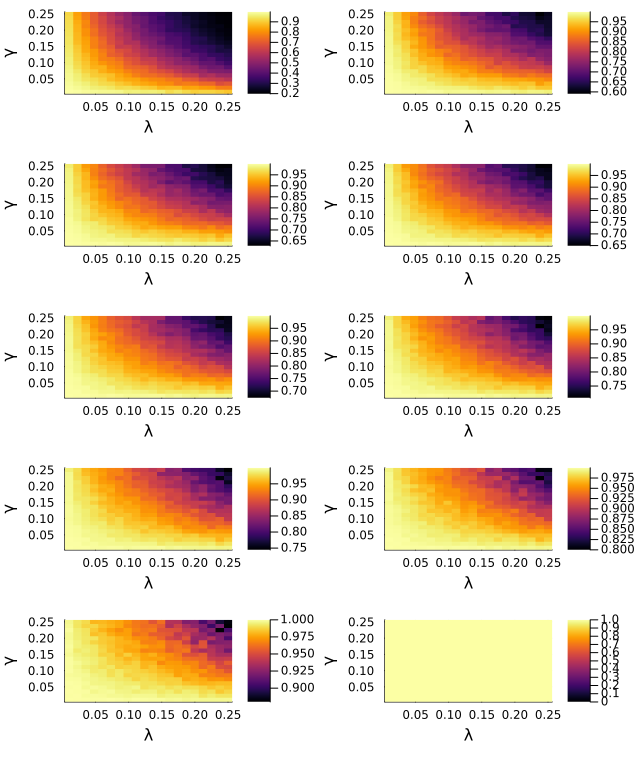

In [4]:
diag = readdlm("$(folderstring)diag.txt")
AUC = zeros(grid,grid,T+2)
for t = 2 : T + 2 
    AUC[:,:,t] .= readdlm("$(folderstring)AUC$(t - 1).txt") 
end

AUC[isnan.(AUC)] .= 1 ;
hdiag = heatmap(γvalues,λvalues,diag)
hAUC = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)

for t = 2 : T + 2 
    hAUC[t-1] = heatmap(γvalues,λvalues,AUC[:,:,t]) 
end

plot(hdiag, hAUC..., size=(640,760),layout = (5, 2),xlabel="λ",ylabel="γ")

#savefig("inference.pdf")

# Phase Space FalseRate - Dilution

In [65]:
grid = 7
T = 8
graphtypes= ["rr","er"]
graph = graphtypes[2]
samp = 4;
d = 3

3

In [66]:
frRange = LinRange(0.0,0.5,grid) # planted autoinfection probability
dilRange = LinRange(0.0,1.0,grid) # planted infection rate
diag = readdlm("./fr_dil_$(graph)_$(samp)/diag.txt")
AUC = zeros(grid,grid,T+2)
for t = 2 : T + 2 
    AUC[:,:,t] .= readdlm("./fr_dil_$(graph)_$(samp)/AUC$(t - 1).txt") 
end

LoadError: ArgumentError: Cannot open './fr_dil_er_4/diag.txt': not a file

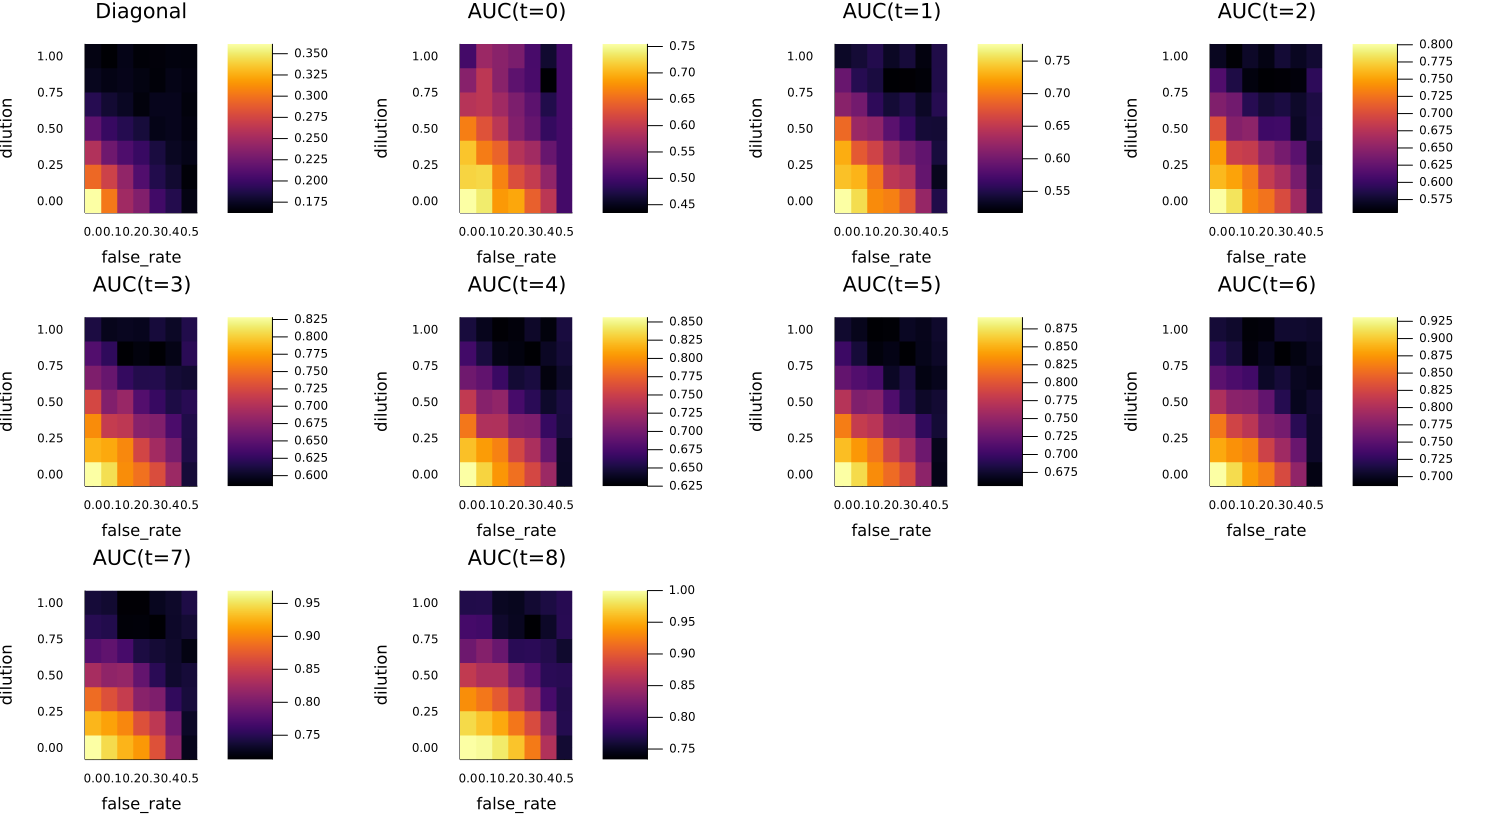

In [6]:
AUC[isnan.(AUC)] .= 1 ;
hdiag = heatmap(frRange,dilRange,diag,title="Diagonal")
hAUC = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)

for t = 2 : T + 2 
    hAUC[t-1] = heatmap(frRange,dilRange,AUC[:,:,t],title="AUC(t=$(t-2))") 
end

plot(hdiag, hAUC..., size=(1500,820),layout = 10,ylabel="dilution",xlabel="false_rate",margin=5Plots.mm)

In [7]:
savefig("fr_dil2.pdf")

# Phase Space Interaction - Dilution

In [32]:
T = 8
d = 3
graphtypes= ["rr","er","ft"]
graph = graphtypes[2]
samp = 10;
grid_λ = 21
grid_dil = 21

21

In [33]:
λRange = LinRange(0.05,0.9,grid_λ)
dilRange = LinRange(0.05,0.9,grid_dil)
path = "./dil_lam_$(graph)_$(samp)/"
ninf = readdlm("$(path)ninf.txt")
Fe = readdlm("$(path)Fe.txt")

AUC = zeros(grid_λ,grid_dil,T+2)
Ov = zeros(grid_λ,grid_dil,T+2)
L1 = zeros(grid_λ,grid_dil,T+2)
MSE = zeros(grid_λ,grid_dil,T+2)
for t = 2 : T + 2 
    AUC[:,:,t] .= readdlm("$(path)AUC$(t - 1).txt") 
    Ov[:,:,t] .= readdlm("$(path)Ov$(t - 1).txt") 
    L1[:,:,t] .= readdlm("$(path)L1_$(t - 1).txt") 
    MSE[:,:,t] .= readdlm("$(path)MSE$(t - 1).txt") 
end

In [34]:
ni = readdlm("./infected/ni_$(graph)_T=$(T)_d=$(d)_lam0.01_1.0.txt")
using Interpolations
itp = LinearInterpolation(LinRange(0.01,1,100),vec(ni));
#ni = [itp(t) for t in λRange];
ni = λRange

21-element LinRange{Float64, Int64}:
 0.05,0.0925,0.135,0.1775,0.22,0.2625,…,0.6875,0.73,0.7725,0.815,0.8575,0.9

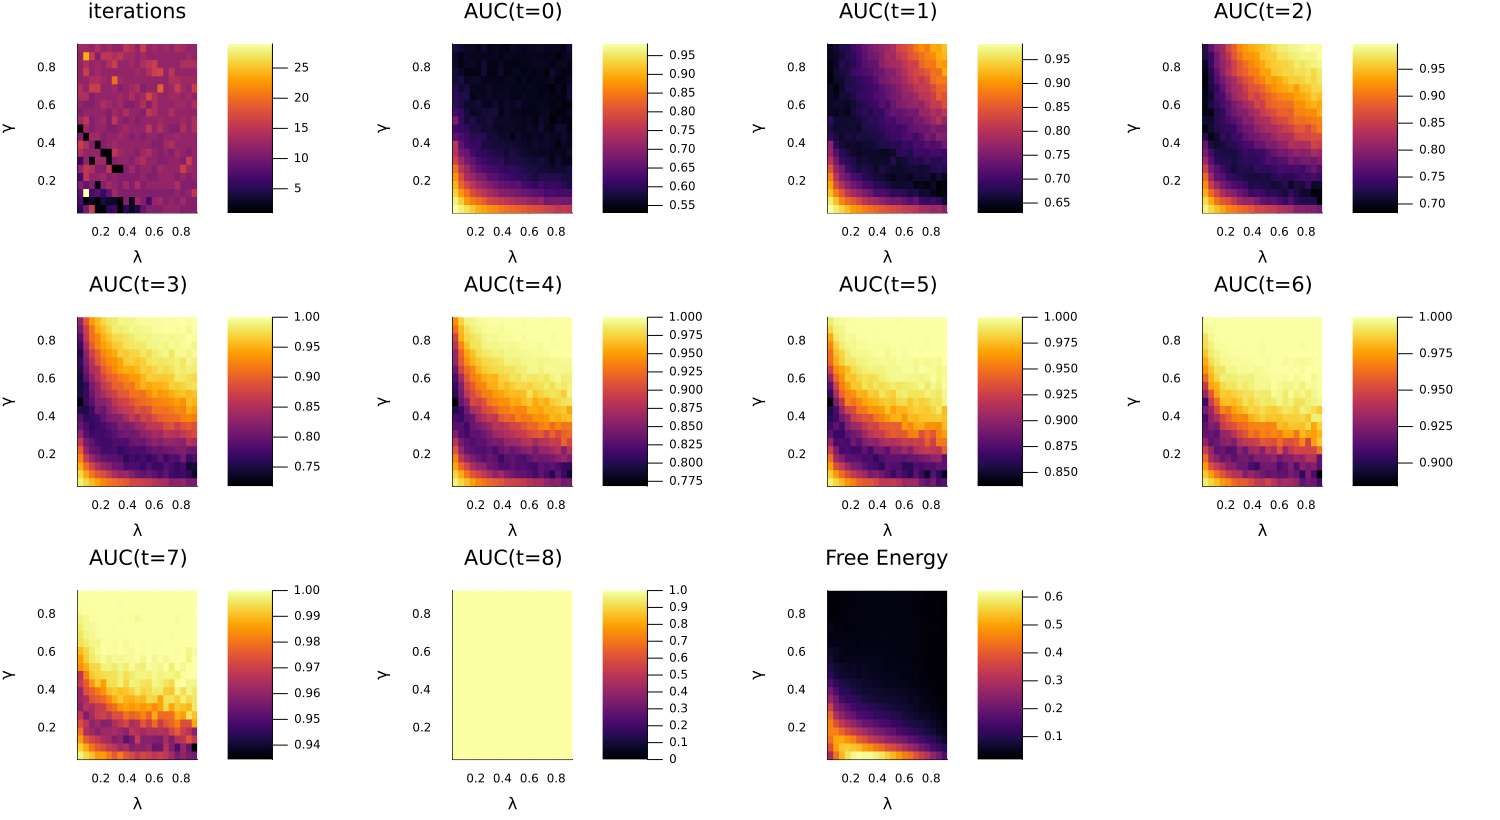

In [38]:
#AUC[isnan.(AUC)] .= 1 ;
hdiag = heatmap(dilRange,ni,ninf,title="iterations")
hfe = heatmap(dilRange,ni,Fe,title="Free Energy")
hAUC = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)
hOv = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)
hL1 = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)
hMSE = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)

for t = 2 : T + 2 
    hAUC[t-1] = heatmap(dilRange,ni,AUC[:,:,t],title="AUC(t=$(t-2))") 
    hOv[t-1] = heatmap(dilRange,ni,Ov[:,:,t],title="Ov(t=$(t-2))") 
    hL1[t-1] = heatmap(dilRange,ni,L1[:,:,t],title="L1(t=$(t-2))") 
    hMSE[t-1] = heatmap(dilRange,ni,MSE[:,:,t],title="MSE(t=$(t-2))") 
end

plot(hdiag, hAUC..., hfe, size=(1500,820),layout = 11,xlabel="λ",ylabel="γ",margin=5Plots.mm)

In [ ]:
savefig("$(path)MSE.pdf")

"/home/students/mmariani/git/Epidemble/results/dil_lam_er_12/MSE.pdf"

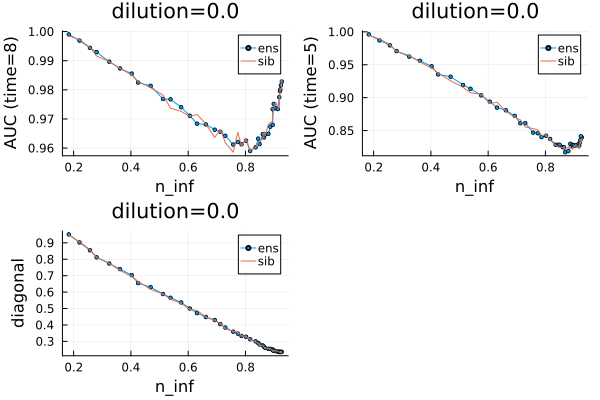

In [10]:
graph = "er"
samp = 1
ni = readdlm("./infected/ni_$(graph)_T=$(T)_d=$(d)_lam0.01_1.0.txt")
using Interpolations
itp = LinearInterpolation(LinRange(0.01,1,100),vec(ni));
ni = [itp(t) for t in LinRange(0.01,0.4,41)];
dil = [0,0.5]
pathtest = "../test/AUCsibyl/"
name = Dict("er" => "poisson", "rr" => "regular")

t = 8
s = 1
a = readdlm("dil_lam_$(graph)_$(samp)/AUC$(t).txt")
p1 = plot(ni,a[:,s],marker=:c,ylabel="AUC (time=$t)",label="ens",xlabel="n_inf",title="dilution=$(dil[s])")
b = readdlm("$(pathtest)$(name[graph])_AUC$(t)_dil_$(dil[s]).txt")
p1 = plot!(ni,b,ylabel="AUC (time=$t)",label="sib",xlabel="n_inf",title="dilution=$(dil[s])")

t = 5
a = readdlm("dil_lam_$(graph)_$(samp)/AUC$(t).txt")
p2 = plot(ni,a[:,s],marker=:c,label="ens",ylabel="AUC (time=$t)",xlabel="n_inf",title="dilution=$(dil[s])")
b = readdlm("$(pathtest)$(name[graph])_AUC$(t)_dil_$(dil[s]).txt")
p2 = plot!(ni,b,ylabel="AUC (time=$t)",label="sib",xlabel="n_inf",title="dilution=$(dil[s])")

a = readdlm("dil_lam_$(graph)_$(samp)/diag.txt")
p3 = plot(ni,a[:,s],marker=:c,label="ens",ylabel="diagonal",xlabel="n_inf",title="dilution=$(dil[s])")
b = readdlm("$(pathtest)$(name[graph])_diag_dil_$(dil[s]).txt")
p3 = plot!(ni,b,xlabel="n_inf",label="sib",title="dilution=$(dil[s])")



pM1 = plot(p1,p2,p3,markersize=2)

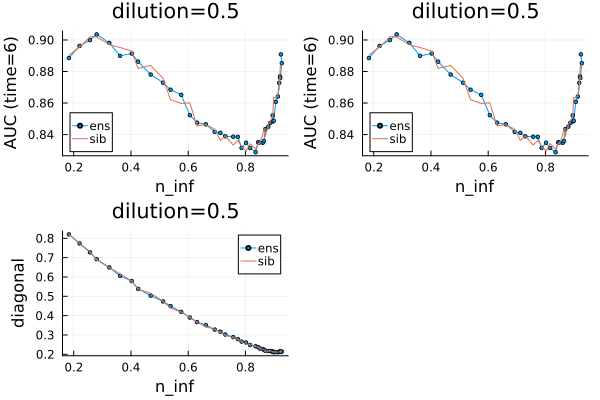

In [115]:
ni = readdlm("./infected/ni_$(graph)_T=$(T)_d=$(d)_lam0.01_1.0.txt")
using Interpolations
itp = LinearInterpolation(LinRange(0.01,1,100),vec(ni));
ni = [itp(t) for t in LinRange(0.01,0.4,41)];
dil = [0,0.5]

pathtest = "../test/AUCsibyl/"


t = 6
s = 2
a = readdlm("dil_lam_$(graph)_$(samp)/AUC$(t).txt")
p4 = plot(ni,a[:,s],marker=:c,ylabel="AUC (time=$t)",label="ens",xlabel="n_inf",title="dilution=$(dil[s])")
b = readdlm("$(pathtest)$(name[graph])_AUC$(t)_dil_$(dil[s]).txt")
p4 = plot!(ni,b,ylabel="AUC (time=$t)",label="sib",xlabel="n_inf",title="dilution=$(dil[s])")

t = 6
a = readdlm("dil_lam_$(graph)_$(samp)/AUC$(t).txt")
p5 = plot(ni,a[:,s],marker=:c,label="ens",ylabel="AUC (time=$t)",xlabel="n_inf",title="dilution=$(dil[s])")
b = readdlm("$(pathtest)$(name[graph])_AUC$(t)_dil_$(dil[s]).txt")
p5 = plot!(ni,b,ylabel="AUC (time=$t)",label="sib",xlabel="n_inf",title="dilution=$(dil[s])")

a = readdlm("dil_lam_$(graph)_$(samp)/diag.txt")
p6 = plot(ni,a[:,s],marker=:c,label="ens",ylabel="diagonal",xlabel="n_inf",title="dilution=$(dil[s])")
b = readdlm("$(pathtest)$(name[graph])_diag_dil_$(dil[s]).txt")
p6 = plot!(ni,b,xlabel="n_inf",label="sib",title="dilution=$(dil[s])")



pM2 = plot(p4,p5,p6,markersize=2)

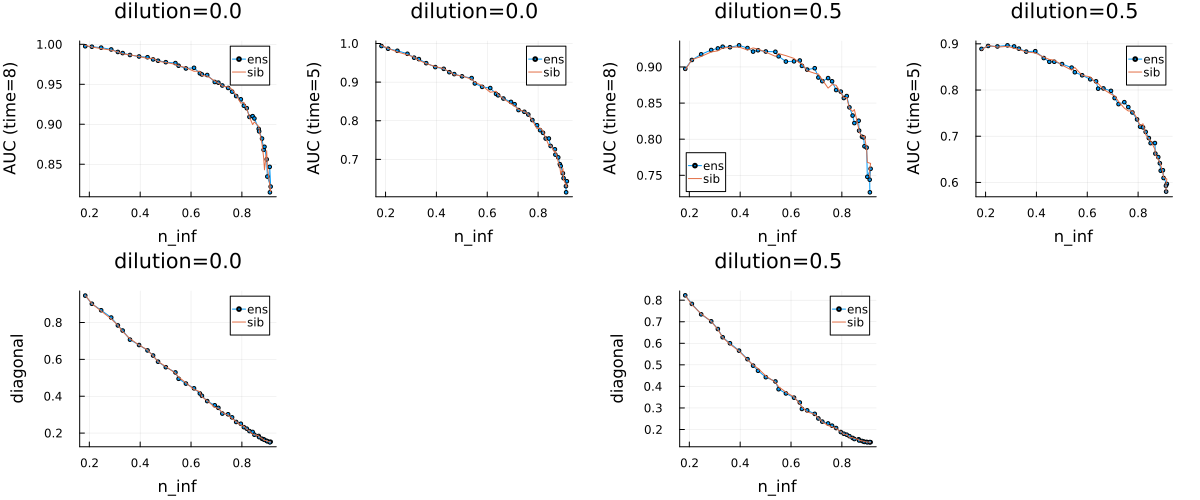

In [89]:
plot(pM1,pM2,layout=(1,2),size=(1200,500),margin=5Plots.mm)

In [76]:
savefig("dil_lam_er_1/AUCnomono.pdf")

"/home/students/mmariani/git/Epidemble/results/dil_lam_er_1/AUCnomono.pdf"